In [1]:
# To create python file:
# jupyter nbconvert --to=python lang_model_new.ipynb

import utils.data_import as data_import
import utils.imdb_data as imdb_data
import utils.ml_utils as ml_utils
import model.neural as neural

import torch
import torch.nn as nn
import torch.optim as optim

from torchtext import data, vocab

import os, sys
import pdb
import pandas as pd
import numpy as np
import math
#from tqdm import tnrange, tqdm_notebook
from tqdm import tqdm

import importlib

import settings

np.random.seed(123)

/anaconda3/envs/ONE/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence


In [2]:
in_notebook = ml_utils.in_ipynb()
print('Running in notebook:', in_notebook)

Running in notebook: True


In [3]:
cuda = torch.cuda.is_available()
if cuda:
    print('Cuda is available!')
    print('Device:', torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print('No cuda.')

if in_notebook:
    import matplotlib.pyplot as plt
    %matplotlib inline

No cuda.


In [4]:
corpus = imdb_data.ImdbCorpus(filename=settings.speaker_id_file, lines=settings.lines_id, 
                              text_col='text', tag_col='tag',
                              vocab_file='vocab.p'
                             )
corpus.train.itoklist_df.head()

Importing vocab from vocab.p... Done.
Imported vocab:  10,954
Read total of: 871 lines from imdb file.
Number of classes: 3: {'Doctor': 0, 'Patient': 1, 'Other': 2}
Generated train: 609 lines
Generated valid: 131 lines
Generated test:  131 lines


,tag,text,len
425,2,"[3, 27, 149, 158, 4704, 7891, 3, 5604, 1832, 4...",19
462,0,"[3, 7893, 16, 1]",4
710,0,"[3, 3532, 849, 2, 11, 2, 20, 16, 1]",9
666,1,"[3, 293, 725, 340, 47, 14, 47, 2, 1828, 16, 1]",11
443,0,"[3, 470, 3339, 5616, 452, 216, 40, 14, 2, 14, ...",21


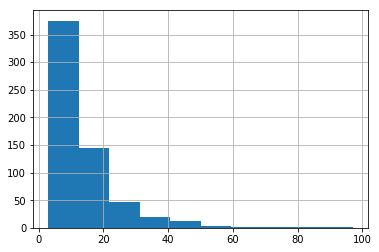

In [5]:
corpus.train.itoklist_df['len'].hist()

In [6]:
train_dl = imdb_data.ImdbTextDataset(corpus.train, pad_idx=corpus.vocab.stoi['<pad>'],
                                     batch_size=settings.batch_size_id, seq_length=settings.window_size_id, 
                                     rand_range=5, sort=True, rebatch_and_shuffle=True)
valid_dl = imdb_data.ImdbTextDataset(corpus.valid, pad_idx=corpus.vocab.stoi['<pad>'],
                                     batch_size=settings.batch_size_id, seq_length=settings.window_size_id, 
                                     rand_range=5, sort=True)
test_dl = imdb_data.ImdbTextDataset(corpus.test, pad_idx=corpus.vocab.stoi['<pad>'],
                                    batch_size=settings.batch_size_id, seq_length=settings.window_size_id, 
                                    rand_range=5, sort=True)

 Number of batches: 10
 Preserved texts: 600
 Matrix size:       torch.Size([134, 60])
 Number of batches: 2
 Preserved texts: 120
 Matrix size:       torch.Size([31, 60])
 Number of batches: 2
 Preserved texts: 120
 Matrix size:       torch.Size([34, 60])


In [7]:
lengths = np.array(train_dl.itoklistFrame.batch_start_end)
lengths = lengths[:,1] - lengths[:,0]
print('sequence lengths per batch:')
print(lengths)

sequence lengths per batch:
[23  6  6  8 18 21 14 12 18  8]


In [8]:
if in_notebook:
    for idx, (x, y) in enumerate(train_dl):
        if idx >= 10:
            break
        print(idx, len(x[:,1]))
        for j in range(len(x[:,1])):
            for i in x[:,j]:
                print(corpus.vocab.itos[i], end=' ')
            print('##', corpus.classes.itos[y[j].item()], '##')

0 22
<upcase> good . <upcase> i would like to get back to <unk> <unk> . <eol> <pad> <pad> <pad> <pad> <pad> <pad> <pad> ## Patient ##
<upcase> yeah . <upcase> i <unk> 't done any <unk> or anything <unk> . <eol> <pad> <pad> <pad> <pad> <pad> <pad> <pad> ## Patient ##
<upcase> yeah . <upcase> yeah . <upcase> let 's hold off on that . <eol> <pad> <pad> <pad> <pad> <pad> <pad> <pad> ## Doctor ##
<upcase> he 's been getting those shots every six months and this time - <eol> <pad> <pad> <pad> <pad> <pad> <pad> <pad> ## Other ##
<upcase> no , it 's going the right way , it 's just - <eol> <pad> <pad> <pad> <pad> <pad> <pad> <pad> ## Patient ##
. . . parked in spots where <upcase> i could just pull out . <eol> <pad> <pad> <pad> <pad> <pad> <pad> <pad> ## Patient ##
<upcase> i 'm gripping stuff better . <upcase> the <unk> is still here . <eol> <pad> <pad> <pad> <pad> <pad> <pad> <pad> ## Patient ##
. . . [ <unk> <unk> ] back and forth and . . . <eol> <pad> <pad> <pad> <pad> <pad> <pad> <pad> ##

In [22]:
model = neural.class_model_LSTM(vocab_dim=len(corpus.vocab),
                                emb_dim=settings.emb_dim,
                                hidden_dim=settings.hidden_dim,
                                n_layers=settings.num_layers,
                                dropout=settings.dropout,
                                n_classes=corpus.n_classes
                               )

In [23]:
if cuda:
    model = model.cuda()

In [24]:
print(model)

class_model_LSTM(
  (embedding): Embedding(28913, 400)
  (lstm): LSTM(400, 1150, num_layers=3, dropout=0.4, bidirectional=True)
  (fc): Linear(in_features=2300, out_features=3, bias=True)
  (dropout): Dropout(p=0.4)
)


In [25]:
#model = torch.load('model_weights_speaker_id.pt')

In [26]:
missclass = []
missclass_next = []
losses = []

In [27]:
def run_epochs(model, train_dl, valid_dl, epochs=settings.epochs,
               losses=[], missclass=[]):
    
    opt = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-6)
    #opt = optim.Adam(model.parameters(), lr=0.001)
    #loss_func = nn.NLLLoss()
    loss_func = nn.CrossEntropyLoss()
    
    scheduler = optim.lr_scheduler.StepLR(opt, step_size=20, gamma=0.8)
    
    best_missclass_te = 1e10
    
    try: # Allow for user interrupt
 
        for epoch in range(1, epochs + 1):
            
            scheduler.step()
            running_loss = 0.0
            running_corrects = 0
            model.train() # turn on training mode

            num_vals = 0
            num_correct = 0

            #pdb.set_trace()

            for x, y in tqdm(train_dl, desc='Train {}/{}'.format(epoch, epochs)):
                opt.zero_grad()
                
                if cuda:
                    x = x.cuda()
                    y = y.cuda()

                preds = model(x)
                loss = loss_func(preds, y.long())

                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 0.25)
                opt.step()

                running_loss += loss.item() * x.size(0) / x.size(1)

                _, y_preds = torch.max(preds, dim=1)
                num_correct += torch.sum(y == y_preds).item()
                num_vals += y.size(0)

            #pdb.set_trace()

            missclass_tr = 1 - num_correct / num_vals

            epoch_loss = running_loss / len(train_dl)

            num_vals = 0
            num_correct = 0

            # calculate the validation loss for this epoch
            val_loss = 0.0
            model.eval() # turn on evaluation mode
            
            with torch.no_grad():
                for x, y in tqdm(valid_dl, desc='Valid {}/{}'.format(epoch, epochs)):
                    if cuda:
                        x = x.cuda()
                        y = y.cuda()   
                        
                    preds = model(x)
                    loss = loss_func(preds, y.long())

                    val_loss += loss.item() * x.size(0) / x.size(1)

                    _, y_preds = torch.max(preds, dim=1)
                    num_correct += torch.sum(y == y_preds).item()
                    num_vals += y.size(0)

            #pdb.set_trace()

            missclass_te = 1 - num_correct / num_vals
            val_loss /= len(valid_dl)
            
            missclass.append((missclass_tr, missclass_te))
            losses.append((epoch_loss, val_loss))

            print('Epoch: {}/{}, Loss: [{:.4f}, {:.4f}], Miss: [{:.2%}, {:.2%}]'\
                  .format(epoch, epochs, epoch_loss, val_loss, 
                          missclass_tr, missclass_te))
            sys.stdout.flush()

            if missclass_te < best_missclass_te:
                print('Improved validation. Saving weights file...', end=' ', flush=True)
                torch.save(model, 'model_weights_speaker_id.pt')
                print('Done.', flush=True)
                best_missclass_te = missclass_te
            
    except KeyboardInterrupt:
        print('Stopping with latest weights.')
        
    return model, opt, losses, missclass

In [28]:
model, opt, losses, missclass = run_epochs(model, train_dl, valid_dl, epochs=settings.epochs,
                                           losses=losses, missclass=missclass)

Valid 1/100: 100%|██████████| 2/2 [00:00<00:00, 71.81it/s]

Epoch: 1/100, Loss: [0.7234, 0.5957], Miss: [56.50%, 61.67%]
Improved validation. Saving weights file... 

Done.


Valid 2/100: 100%|██████████| 2/2 [00:00<00:00, 71.41it/s]

Epoch: 2/100, Loss: [0.6251, 0.5810], Miss: [61.17%, 67.50%]



Valid 3/100: 100%|██████████| 2/2 [00:00<00:00, 71.50it/s]

Epoch: 3/100, Loss: [0.3487, 0.6679], Miss: [59.00%, 83.33%]



Valid 4/100: 100%|██████████| 2/2 [00:00<00:00, 65.05it/s]

Epoch: 4/100, Loss: [0.2075, 0.2940], Miss: [50.33%, 61.67%]



Valid 5/100: 100%|██████████| 2/2 [00:00<00:00, 71.10it/s]

Epoch: 5/100, Loss: [0.2481, 0.2366], Miss: [60.50%, 54.17%]
Improved validation. Saving weights file... 

Done.


Valid 6/100: 100%|██████████| 2/2 [00:00<00:00, 71.99it/s]

Epoch: 6/100, Loss: [0.2730, 0.2527], Miss: [56.83%, 62.50%]



Valid 7/100: 100%|██████████| 2/2 [00:00<00:00, 71.08it/s]

Epoch: 7/100, Loss: [0.2022, 0.2297], Miss: [53.00%, 55.83%]



Valid 8/100: 100%|██████████| 2/2 [00:00<00:00, 70.95it/s]

Epoch: 8/100, Loss: [0.2061, 0.2269], Miss: [50.00%, 44.17%]
Improved validation. Saving weights file... 

Done.


Valid 9/100: 100%|██████████| 2/2 [00:00<00:00, 71.57it/s]

Epoch: 9/100, Loss: [0.2102, 0.2474], Miss: [49.17%, 55.83%]



Valid 10/100: 100%|██████████| 2/2 [00:00<00:00, 71.78it/s]

Epoch: 10/100, Loss: [0.2167, 0.2428], Miss: [47.50%, 53.33%]



Valid 11/100: 100%|██████████| 2/2 [00:00<00:00, 71.42it/s]

Epoch: 11/100, Loss: [0.2024, 0.2133], Miss: [47.00%, 47.50%]



Valid 12/100: 100%|██████████| 2/2 [00:00<00:00, 71.43it/s]

Epoch: 12/100, Loss: [0.2171, 0.2596], Miss: [46.00%, 56.67%]



Valid 13/100: 100%|██████████| 2/2 [00:00<00:00, 71.77it/s]

Epoch: 13/100, Loss: [0.2208, 0.2215], Miss: [50.33%, 38.33%]
Improved validation. Saving weights file... 

Done.


Valid 14/100: 100%|██████████| 2/2 [00:00<00:00, 68.81it/s]

Epoch: 14/100, Loss: [0.1752, 0.2418], Miss: [35.50%, 45.83%]



Valid 15/100: 100%|██████████| 2/2 [00:00<00:00, 71.01it/s]

Epoch: 15/100, Loss: [0.2028, 0.2676], Miss: [39.33%, 57.50%]



Valid 16/100: 100%|██████████| 2/2 [00:00<00:00, 71.68it/s]

Epoch: 16/100, Loss: [0.2143, 0.2545], Miss: [41.83%, 38.33%]



Valid 17/100: 100%|██████████| 2/2 [00:00<00:00, 70.37it/s]

Epoch: 17/100, Loss: [0.1816, 0.2355], Miss: [30.83%, 35.83%]
Improved validation. Saving weights file... 

Done.


Valid 18/100: 100%|██████████| 2/2 [00:00<00:00, 71.33it/s]

Epoch: 18/100, Loss: [0.1976, 0.2301], Miss: [34.67%, 47.50%]



Valid 19/100: 100%|██████████| 2/2 [00:00<00:00, 71.73it/s]

Epoch: 19/100, Loss: [0.2011, 0.2448], Miss: [39.83%, 52.50%]



Valid 20/100: 100%|██████████| 2/2 [00:00<00:00, 71.72it/s]

Epoch: 20/100, Loss: [0.1861, 0.2318], Miss: [41.33%, 48.33%]



Valid 21/100: 100%|██████████| 2/2 [00:00<00:00, 71.83it/s]

Epoch: 21/100, Loss: [0.1688, 0.2229], Miss: [32.50%, 32.50%]
Improved validation. Saving weights file... 

Done.


Valid 22/100: 100%|██████████| 2/2 [00:00<00:00, 71.83it/s]

Epoch: 22/100, Loss: [0.1654, 0.2243], Miss: [31.17%, 34.17%]



Valid 23/100: 100%|██████████| 2/2 [00:00<00:00, 71.53it/s]

Epoch: 23/100, Loss: [0.1985, 0.2138], Miss: [31.67%, 33.33%]



Valid 24/100: 100%|██████████| 2/2 [00:00<00:00, 71.78it/s]

Epoch: 24/100, Loss: [0.1938, 0.2180], Miss: [29.00%, 34.17%]



Valid 25/100: 100%|██████████| 2/2 [00:00<00:00, 70.44it/s]

Epoch: 25/100, Loss: [0.1675, 0.2166], Miss: [28.33%, 32.50%]



Valid 26/100: 100%|██████████| 2/2 [00:00<00:00, 71.72it/s]

Epoch: 26/100, Loss: [0.1601, 0.2137], Miss: [28.00%, 31.67%]
Improved validation. Saving weights file... 

Done.


Valid 27/100: 100%|██████████| 2/2 [00:00<00:00, 71.43it/s]

Epoch: 27/100, Loss: [0.1570, 0.2216], Miss: [27.50%, 30.83%]
Improved validation. Saving weights file... 

Done.


Valid 28/100: 100%|██████████| 2/2 [00:00<00:00, 71.49it/s]

Epoch: 28/100, Loss: [0.1692, 0.2269], Miss: [28.17%, 40.83%]



Valid 29/100: 100%|██████████| 2/2 [00:00<00:00, 71.29it/s]

Epoch: 29/100, Loss: [0.1591, 0.2348], Miss: [28.83%, 37.50%]



Valid 30/100: 100%|██████████| 2/2 [00:00<00:00, 71.47it/s]

Epoch: 30/100, Loss: [0.1786, 0.2107], Miss: [29.33%, 31.67%]



Valid 31/100: 100%|██████████| 2/2 [00:00<00:00, 71.21it/s]

Epoch: 31/100, Loss: [0.1721, 0.2055], Miss: [29.17%, 35.00%]



Valid 32/100: 100%|██████████| 2/2 [00:00<00:00, 71.54it/s]

Epoch: 32/100, Loss: [0.1572, 0.2328], Miss: [27.50%, 37.50%]



Valid 33/100: 100%|██████████| 2/2 [00:00<00:00, 71.59it/s]

Epoch: 33/100, Loss: [0.1560, 0.2177], Miss: [26.17%, 37.50%]



Valid 34/100: 100%|██████████| 2/2 [00:00<00:00, 71.40it/s]

Epoch: 34/100, Loss: [0.1817, 0.2228], Miss: [26.67%, 35.00%]



Valid 35/100: 100%|██████████| 2/2 [00:00<00:00, 71.65it/s]

Epoch: 35/100, Loss: [0.1352, 0.2113], Miss: [25.50%, 32.50%]



Valid 36/100: 100%|██████████| 2/2 [00:00<00:00, 71.45it/s]

Epoch: 36/100, Loss: [0.1675, 0.2191], Miss: [27.67%, 34.17%]



Valid 37/100: 100%|██████████| 2/2 [00:00<00:00, 71.39it/s]

Epoch: 37/100, Loss: [0.1448, 0.2267], Miss: [30.17%, 39.17%]



Valid 38/100: 100%|██████████| 2/2 [00:00<00:00, 71.60it/s]

Epoch: 38/100, Loss: [0.1516, 0.2625], Miss: [27.50%, 48.33%]



Valid 39/100: 100%|██████████| 2/2 [00:00<00:00, 71.61it/s]

Epoch: 39/100, Loss: [0.1518, 0.2006], Miss: [28.17%, 30.00%]
Improved validation. Saving weights file... 

Done.


Valid 40/100: 100%|██████████| 2/2 [00:00<00:00, 71.68it/s]

Epoch: 40/100, Loss: [0.1371, 0.2136], Miss: [25.33%, 33.33%]



Valid 41/100: 100%|██████████| 2/2 [00:00<00:00, 68.70it/s]

Epoch: 41/100, Loss: [0.1422, 0.2287], Miss: [24.83%, 35.83%]



Valid 42/100: 100%|██████████| 2/2 [00:00<00:00, 71.46it/s]

Epoch: 42/100, Loss: [0.1500, 0.2451], Miss: [25.50%, 34.17%]



Valid 43/100: 100%|██████████| 2/2 [00:00<00:00, 71.05it/s]

Epoch: 43/100, Loss: [0.1240, 0.2121], Miss: [23.67%, 34.17%]



Valid 44/100: 100%|██████████| 2/2 [00:00<00:00, 71.81it/s]

Epoch: 44/100, Loss: [0.1438, 0.2328], Miss: [26.83%, 34.17%]



Valid 45/100: 100%|██████████| 2/2 [00:00<00:00, 71.56it/s]

Epoch: 45/100, Loss: [0.1682, 0.2165], Miss: [24.67%, 30.83%]



Valid 46/100: 100%|██████████| 2/2 [00:00<00:00, 71.24it/s]

Epoch: 46/100, Loss: [0.1154, 0.2048], Miss: [23.83%, 35.00%]



Valid 47/100: 100%|██████████| 2/2 [00:00<00:00, 71.32it/s]

Epoch: 47/100, Loss: [0.1306, 0.2061], Miss: [23.00%, 30.00%]



Valid 48/100: 100%|██████████| 2/2 [00:00<00:00, 71.18it/s]

Epoch: 48/100, Loss: [0.1208, 0.1945], Miss: [23.67%, 30.00%]



Valid 49/100: 100%|██████████| 2/2 [00:00<00:00, 71.01it/s]

Epoch: 49/100, Loss: [0.1341, 0.2101], Miss: [22.17%, 30.83%]



Valid 50/100: 100%|██████████| 2/2 [00:00<00:00, 71.66it/s]

Epoch: 50/100, Loss: [0.1454, 0.2064], Miss: [23.50%, 33.33%]



Valid 51/100: 100%|██████████| 2/2 [00:00<00:00, 71.58it/s]

Epoch: 51/100, Loss: [0.1427, 0.2368], Miss: [23.67%, 34.17%]



Valid 52/100: 100%|██████████| 2/2 [00:00<00:00, 71.56it/s]

Epoch: 52/100, Loss: [0.1371, 0.2414], Miss: [24.83%, 33.33%]



Valid 53/100: 100%|██████████| 2/2 [00:00<00:00, 71.54it/s]

Epoch: 53/100, Loss: [0.1198, 0.2664], Miss: [22.50%, 31.67%]



Valid 54/100: 100%|██████████| 2/2 [00:00<00:00, 70.83it/s]

Epoch: 54/100, Loss: [0.1278, 0.2233], Miss: [22.67%, 34.17%]



Valid 55/100: 100%|██████████| 2/2 [00:00<00:00, 71.67it/s]

Epoch: 55/100, Loss: [0.1683, 0.2153], Miss: [25.17%, 35.83%]



Valid 56/100: 100%|██████████| 2/2 [00:00<00:00, 71.48it/s]

Epoch: 56/100, Loss: [0.1324, 0.2356], Miss: [20.83%, 36.67%]



Valid 57/100: 100%|██████████| 2/2 [00:00<00:00, 71.45it/s]

Epoch: 57/100, Loss: [0.1382, 0.2400], Miss: [22.33%, 35.00%]



Valid 58/100: 100%|██████████| 2/2 [00:00<00:00, 71.23it/s]

Epoch: 58/100, Loss: [0.1120, 0.2751], Miss: [21.17%, 30.83%]



Valid 59/100: 100%|██████████| 2/2 [00:00<00:00, 71.15it/s]

Epoch: 59/100, Loss: [0.1078, 0.2224], Miss: [20.83%, 35.00%]



Valid 60/100: 100%|██████████| 2/2 [00:00<00:00, 71.04it/s]

Epoch: 60/100, Loss: [0.1087, 0.2340], Miss: [19.50%, 35.00%]



Valid 61/100: 100%|██████████| 2/2 [00:00<00:00, 71.32it/s]

Epoch: 61/100, Loss: [0.0989, 0.2887], Miss: [17.83%, 43.33%]



Valid 62/100: 100%|██████████| 2/2 [00:00<00:00, 71.33it/s]

Epoch: 62/100, Loss: [0.1250, 0.2111], Miss: [22.17%, 30.83%]



Valid 63/100: 100%|██████████| 2/2 [00:00<00:00, 71.51it/s]

Epoch: 63/100, Loss: [0.1071, 0.2442], Miss: [17.50%, 30.83%]



Valid 64/100: 100%|██████████| 2/2 [00:00<00:00, 71.48it/s]

Epoch: 64/100, Loss: [0.0978, 0.2428], Miss: [18.50%, 30.00%]



Valid 65/100: 100%|██████████| 2/2 [00:00<00:00, 71.61it/s]

Epoch: 65/100, Loss: [0.0821, 0.2658], Miss: [15.50%, 31.67%]



Valid 66/100: 100%|██████████| 2/2 [00:00<00:00, 71.80it/s]

Epoch: 66/100, Loss: [0.0942, 0.3221], Miss: [16.17%, 35.00%]



Valid 67/100: 100%|██████████| 2/2 [00:00<00:00, 70.51it/s]

Epoch: 67/100, Loss: [0.0706, 0.2970], Miss: [15.00%, 33.33%]



Valid 68/100: 100%|██████████| 2/2 [00:00<00:00, 71.11it/s]

Epoch: 68/100, Loss: [0.0852, 0.2964], Miss: [15.17%, 28.33%]
Improved validation. Saving weights file... 

Done.


Valid 69/100: 100%|██████████| 2/2 [00:00<00:00, 71.00it/s]

Epoch: 69/100, Loss: [0.0783, 0.2972], Miss: [13.83%, 32.50%]



Valid 70/100: 100%|██████████| 2/2 [00:00<00:00, 71.58it/s]

Epoch: 70/100, Loss: [0.0790, 0.2712], Miss: [15.17%, 31.67%]



Valid 71/100: 100%|██████████| 2/2 [00:00<00:00, 71.43it/s]

Epoch: 71/100, Loss: [0.0618, 0.2810], Miss: [13.83%, 32.50%]



Valid 72/100: 100%|██████████| 2/2 [00:00<00:00, 71.09it/s]

Epoch: 72/100, Loss: [0.0754, 0.3121], Miss: [16.83%, 34.17%]



Valid 73/100: 100%|██████████| 2/2 [00:00<00:00, 71.57it/s]

Epoch: 73/100, Loss: [0.0467, 0.3712], Miss: [12.00%, 32.50%]



Valid 74/100: 100%|██████████| 2/2 [00:00<00:00, 71.74it/s]

Epoch: 74/100, Loss: [0.0483, 0.3770], Miss: [11.83%, 30.83%]



Valid 75/100: 100%|██████████| 2/2 [00:00<00:00, 71.40it/s]

Epoch: 75/100, Loss: [0.0705, 0.3312], Miss: [13.17%, 29.17%]



Valid 76/100: 100%|██████████| 2/2 [00:00<00:00, 71.36it/s]

Epoch: 76/100, Loss: [0.0571, 0.3145], Miss: [12.50%, 29.17%]



Valid 77/100: 100%|██████████| 2/2 [00:00<00:00, 71.51it/s]

Epoch: 77/100, Loss: [0.0461, 0.3777], Miss: [10.33%, 33.33%]



Valid 78/100: 100%|██████████| 2/2 [00:00<00:00, 70.59it/s]

Epoch: 78/100, Loss: [0.0498, 0.3611], Miss: [11.50%, 31.67%]



Valid 79/100: 100%|██████████| 2/2 [00:00<00:00, 71.39it/s]

Epoch: 79/100, Loss: [0.0711, 0.3636], Miss: [12.83%, 28.33%]



Valid 80/100: 100%|██████████| 2/2 [00:00<00:00, 71.34it/s]

Epoch: 80/100, Loss: [0.0510, 0.3759], Miss: [10.67%, 33.33%]



Valid 81/100: 100%|██████████| 2/2 [00:00<00:00, 71.21it/s]

Epoch: 81/100, Loss: [0.0488, 0.3965], Miss: [11.33%, 29.17%]



Valid 82/100: 100%|██████████| 2/2 [00:00<00:00, 71.58it/s]

Epoch: 82/100, Loss: [0.0408, 0.4053], Miss: [11.67%, 33.33%]



Valid 83/100: 100%|██████████| 2/2 [00:00<00:00, 71.16it/s]

Epoch: 83/100, Loss: [0.0432, 0.3661], Miss: [12.33%, 30.00%]



Valid 84/100: 100%|██████████| 2/2 [00:00<00:00, 71.21it/s]

Epoch: 84/100, Loss: [0.0410, 0.3564], Miss: [11.00%, 39.17%]



Valid 85/100: 100%|██████████| 2/2 [00:00<00:00, 70.97it/s]

Epoch: 85/100, Loss: [0.0318, 0.3885], Miss: [9.17%, 27.50%]
Improved validation. Saving weights file... 

Done.


Valid 86/100: 100%|██████████| 2/2 [00:00<00:00, 70.66it/s]

Epoch: 86/100, Loss: [0.0571, 0.4090], Miss: [10.83%, 28.33%]



Valid 87/100: 100%|██████████| 2/2 [00:00<00:00, 71.51it/s]

Epoch: 87/100, Loss: [0.0416, 0.3854], Miss: [10.50%, 32.50%]



Valid 88/100: 100%|██████████| 2/2 [00:00<00:00, 70.50it/s]

Epoch: 88/100, Loss: [0.0458, 0.3334], Miss: [11.00%, 30.83%]



Valid 89/100: 100%|██████████| 2/2 [00:00<00:00, 70.81it/s]

Epoch: 89/100, Loss: [0.0306, 0.3599], Miss: [9.67%, 29.17%]



Valid 90/100: 100%|██████████| 2/2 [00:00<00:00, 71.32it/s]

Epoch: 90/100, Loss: [0.0335, 0.3706], Miss: [9.17%, 30.00%]



Valid 91/100: 100%|██████████| 2/2 [00:00<00:00, 71.23it/s]

Epoch: 91/100, Loss: [0.0271, 0.4517], Miss: [9.17%, 30.00%]



Valid 92/100: 100%|██████████| 2/2 [00:00<00:00, 70.81it/s]

Epoch: 92/100, Loss: [0.0329, 0.4707], Miss: [8.33%, 29.17%]



Valid 93/100: 100%|██████████| 2/2 [00:00<00:00, 71.09it/s]

Epoch: 93/100, Loss: [0.0283, 0.4852], Miss: [9.17%, 33.33%]



Valid 94/100: 100%|██████████| 2/2 [00:00<00:00, 70.81it/s]

Epoch: 94/100, Loss: [0.0276, 0.5534], Miss: [8.50%, 33.33%]



Valid 95/100: 100%|██████████| 2/2 [00:00<00:00, 71.11it/s]

Epoch: 95/100, Loss: [0.0292, 0.5956], Miss: [8.83%, 34.17%]



Valid 96/100: 100%|██████████| 2/2 [00:00<00:00, 71.08it/s]

Epoch: 96/100, Loss: [0.0349, 0.4923], Miss: [8.17%, 35.00%]



Valid 97/100: 100%|██████████| 2/2 [00:00<00:00, 71.21it/s]

Epoch: 97/100, Loss: [0.0284, 0.4739], Miss: [8.50%, 33.33%]



Valid 98/100: 100%|██████████| 2/2 [00:00<00:00, 70.98it/s]

Epoch: 98/100, Loss: [0.0247, 0.5233], Miss: [8.83%, 35.00%]



Valid 99/100: 100%|██████████| 2/2 [00:00<00:00, 71.52it/s]

Epoch: 99/100, Loss: [0.0306, 0.5664], Miss: [8.83%, 35.00%]



Valid 100/100: 100%|██████████| 2/2 [00:00<00:00, 71.11it/s]

Epoch: 100/100, Loss: [0.0295, 0.5403], Miss: [9.00%, 31.67%]


In [29]:
x, y = next(iter(valid_dl))
if cuda:
    x = x.cuda()
    y = y.cuda()
loss_func = nn.CrossEntropyLoss()
preds = model(x)
_, y_preds = torch.max(preds, dim=1)
loss = loss_func(preds, y.long())
loss

tensor(2.3640, device='cuda:0', grad_fn=<NllLossBackward>)

In [30]:
print(y.shape)
print(y[:])

torch.Size([60])
tensor([1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1,
        0, 1, 1, 1, 1, 0, 1, 0, 2, 1, 1, 1, 0, 2, 0, 1, 2, 1, 0, 1, 1, 2, 1, 1,
        1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 2], device='cuda:0')


In [31]:
print(y_preds[:])
print(preds)

tensor([1, 1, 1, 0, 1, 1, 2, 2, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 2,
        1, 1, 2, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 2,
        1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 0, 2], device='cuda:0')
tensor([[-2.9134,  8.9894, -2.7472],
        [-1.3814,  2.7518, -0.7585],
        [-2.8680, 11.0893, -4.2317],
        [ 6.8768, -1.8920, -2.3301],
        [-2.2565,  5.1861,  0.1614],
        [-2.9596, 10.5690, -3.9475],
        [-0.7743, -1.3633,  0.9433],
        [-4.5001, -4.3665,  8.7878],
        [ 6.8919, -2.7788, -1.9453],
        [-2.8057, 10.8765, -4.2454],
        [ 5.8457, -1.7918, -2.0701],
        [-1.3525,  3.5023, -1.4944],
        [ 3.9887, -2.7217, -0.8481],
        [ 6.5153, -1.9030, -2.1798],
        [ 1.7269,  0.2773, -1.4407],
        [ 5.6513, -1.3962, -2.2793],
        [-1.9182,  4.1985, -2.1228],
        [-1.1791,  4.8220, -2.3851],
        [ 6.7917, -1.7512, -2.3698],
        [ 6.1277, -1.4977, -2.1855],
        [-2.9797, 10.7019, -4.0286],
 

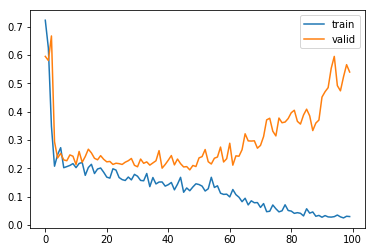

In [32]:
if in_notebook:
    plt.plot(losses)
    plt.legend(['train', 'valid'])

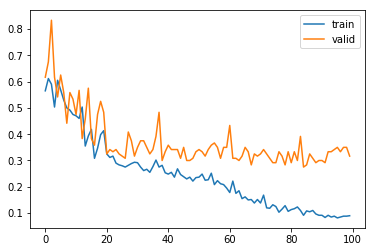

In [33]:
if in_notebook:
    plt.plot(missclass)
    plt.legend(['train', 'valid'])